In [1]:
import pickle
import pandas as pd
import os
from utils.plot_decision_trees import plot_tree


from utils.pre_process_data import get_data
from math import ceil
from utils.units import Volume, Dollar
from deap import gp, creator, base, tools
from deap.gp import Terminal
from operator import or_, and_, gt
from fitness_functions import *
from utils.plot_decision_trees import plot_tree
from utils.save_info import save_results
from genetic_functions.cx_functions import cxSubTree
from genetic_functions.mut_functions import mutation_half, mutBranch
from genetic_functions.genetic_program import GPAlgo
import matplotlib.pyplot as plt
import pendulum


In [2]:
df = get_data()
df_train= df.iloc[ : ceil(len(df)*0.7)]
df_test= df.iloc[ceil(len(df)*0.7) : ]

arg_names = list(df_train.columns)
vol_args = [arg for arg in arg_names if "volume" in arg.lower()]
dol_args = [arg for arg in arg_names if "volume" not in arg.lower()]


pset = gp.PrimitiveSetTyped("main",[Volume]*len(vol_args) + [Dollar]*len(dol_args),bool)
        #Rename the arguments:
arg_vol_mapping = {f"ARG{ind}": val for ind,val in enumerate(vol_args)}
pset.renameArguments(**arg_vol_mapping)
arg_dol_mapping = {f"ARG{len(vol_args)+ind}": val for ind,val in enumerate(dol_args)}
pset.renameArguments(**arg_dol_mapping)
#Check that all arguments were renamed:
unnamed_args=[i for i in pset.arguments if "ARG" in i]
if  unnamed_args:
    print(f"Some arguments were not renamed: {unnamed_args}")
pset.addPrimitive(gt, [Dollar,Dollar],bool)
pset.addPrimitive(lambda x:x ,[Dollar],Dollar, name="dollar placeholder")

pset.addPrimitive(gt, [Volume,Volume],bool)
pset.addPrimitive(lambda x:x ,[Volume],Volume, name="volume placeholder")


#Boolean operators:
pset.addPrimitive(and_, [bool,bool],bool)
pset.addPrimitive(or_,[bool,bool],bool)

for v_arg in vol_args:
        pset.addTerminal(v_arg,Volume)
for d_arg in dol_args:
        pset.addTerminal(d_arg,Dollar)

# --- Remove all the ARG terminals ---
pset.terminals[Volume] = [i for i in pset.terminals[Volume] if "ARG" not in i.name]
pset.terminals[Dollar] = [i for i in pset.terminals[Dollar] if "ARG" not in i.name]

def generate(pset):
    run=True
    while run:
        try:
            expr = toolbox.individual()            
            #Remove all the Lambda functions:
            expr=  list(filter(lambda x: x.name!="dollar placeholder", expr))
            expr=  list(filter(lambda x: x.name!="volume placeholder", expr))
            if len(expr)>3:
                run=False
        except IndexError:
            continue
    # return gp.PrimitiveTree(expr)
    return creator.Individual(expr)

# --- GP OPERATORS ----

creator.create("fitness", base.Fitness, weights=(1,))
creator.create("Individual", gp.PrimitiveTree, fitness= creator.fitness)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("custom_individual",generate, pset)
toolbox.register("population", tools.initRepeat, list, toolbox.custom_individual)
toolbox.register("evaluate", fitness_function, df=df_train, pset=pset)

toolbox.register("mate",       cxSubTree)
toolbox.register("select",     tools.selRanked) 
toolbox.register("mutate",     mutation_half, pset=pset)

hof   = tools.HallOfFame(maxsize=50)

#STATS:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0) 
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

/home/khann/masters/utils/pre_process_data.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"lag_{column.lower()}_{lag}"]= df[column].shift(lag)
/home/khann/masters/utils/pre_process_data.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"lag_{column.lower()}_{lag}"]= df[column].shift(lag)
/home/khann/masters/utils/pre_process_data.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at

In [17]:
run_list = os.listdir("results")

In [18]:
best_sol_pop = []
for dir in run_list:
    if os.path.isdir(rf"/home/khann/masters/results/{dir}"):
        with open(rf"/home/khann/masters/results/{dir}/hof.pkl", 'rb') as file:
        # Serialize the object and write it to the file
            hof = pickle.load(file)
            best_sol_pop.append(hof[0])
            best_sol_pop.append(hof[1])

[[<deap.gp.Primitive at 0x7f2649a5fce0>,

In [94]:
best_sol_pop = []
cnt=0
for dir in run_list:
    if os.path.isdir(rf"/home/khann/masters/results/{dir}"):
        if cnt == 0:
            df_tmp = pd.read_csv(rf"/home/khann/masters/results/{dir}/run_info.csv")
            df_tmp.drop('Unnamed: 0',axis=1, inplace=True)
        else:
            d = pd.read_csv(rf"/home/khann/masters/results/{dir}/run_info.csv")
            d.drop('Unnamed: 0',axis=1, inplace=True)
            df_tmp = pd.concat([df_tmp, d], ignore_index=True, sort=False)
        cnt+=1


In [98]:
df_tmp[df_tmp['strategy_value_train']>df_tmp['buy_hold_train']]


,population_number,generations,run_time,best_tree,trading_cost,buy_hold_train,strategy_value_train,buy_hold_test,strategy_value_test,time
0,100,50,24196,"or_(or_(gt('ma_volume_37', 'ma_volume_28'), gt...",1.0%,116918.977037,124921.446777,1163.710097,748.707034,2024-08-03 08:58:23.600744+00:00
2,100,50,24047,"or_(gt('ma_volume_48', 'ma_volume_23'), gt('ma...",1.0%,116918.977037,245421.647930,1163.710097,753.986999,2024-08-03 08:58:25.831189+00:00
7,100,50,24200,"or_(gt('lag_open_3', 'ma_low_28'), or_(gt('ma_...",1.0%,116918.977037,143223.130798,1163.710097,855.106895,2024-08-03 08:58:26.610248+00:00
9,100,50,24034,"or_(or_(gt('ma_volume_38', 'ma_volume_23'), gt...",1.0%,116918.977037,150489.699506,1163.710097,759.650024,2024-08-03 08:58:26.059060+00:00
10,100,50,23797,"or_(gt('ma_close_26', 'lag_close_42'), gt('ma_...",1.0%,116918.977037,152655.699058,1163.710097,902.983195,2024-08-03 08:58:26.471382+00:00
13,100,50,24073,"or_(gt('ma_close_15', 'ma_low_20'), gt('ma_vol...",1.0%,116918.977037,153294.053086,1163.710097,587.801277,2024-08-03 08:58:23.553530+00:00
14,100,50,23627,"or_(gt('ma_volume_37', 'ma_volume_22'), gt('ma...",1.0%,116918.977037,122542.497667,1163.710097,690.661582,2024-08-03 08:58:26.259925+00:00
19,100,50,24009,"or_(gt('ma_volume_44', 'ma_volume_21'), gt('ma...",1.0%,116918.977037,167054.636840,1163.710097,332.160944,2024-08-03 08:58:23.068494+00:00
20,100,50,24024,"or_(gt('ma_high_13', 'ma_open_19'), gt('ma_clo...",1.0%,116918.977037,165748.828462,1163.710097,873.909993,2024-08-03 08:58:25.932072+00:00
23,100,50,23520,"or_(or_(gt('ma_volume_49', 'ma_volume_32'), or...",1.0%,116918.977037,127655.415784,1163.710097,633.208535,2024-08-03 08:58:25.934185+00:00


<Axes: >

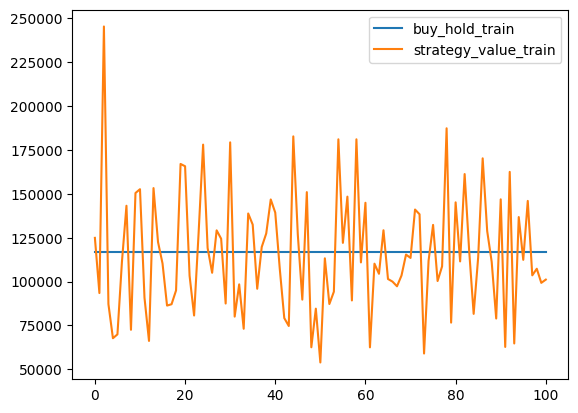

In [100]:
df_tmp[['buy_hold_train', 'strategy_value_train']].plot()

In [84]:
d = pd.concat([d, t], ignore_index=True, sort=False)
d

,Unnamed: 0,population_number,generations,run_time,best_tree,trading_cost,buy_hold_train,strategy_value_train,buy_hold_test,strategy_value_test,time
0,0,100,50,24148,"or_(gt('ma_close_9', 'ma_close_41'), gt('ma_vo...",1.0%,116918.977037,93458.631839,1163.710097,690.440269,2024-08-03 08:58:26.549738+00:00
1,0,100,50,24148,"or_(gt('ma_close_9', 'ma_close_41'), gt('ma_vo...",1.0%,116918.977037,93458.631839,1163.710097,690.440269,2024-08-03 08:58:26.549738+00:00
2,0,100,50,24148,"or_(gt('ma_close_9', 'ma_close_41'), gt('ma_vo...",1.0%,116918.977037,93458.631839,1163.710097,690.440269,2024-08-03 08:58:26.549738+00:00
3,0,100,50,24148,"or_(gt('ma_close_9', 'ma_close_41'), gt('ma_vo...",1.0%,116918.977037,93458.631839,1163.710097,690.440269,2024-08-03 08:58:26.549738+00:00


In [21]:
hof.items[0]

In [22]:
# res = pd.read_csv(r"/home/khann/masters/results/run_2024-08-03_08-38/run_info.csv")
# res.columns

In [23]:
best_sol_pop.sort(key = lambda x : x.fitness.values)

In [24]:
plot_tree(best_sol_pop[0] , name="tree_gen1_best_sol")

In [25]:
best_sol_pop

[[<deap.gp.Primitive at 0x7f264c240fe0>,

In [26]:
for i in best_sol_pop:
    per = [k for k in str(i).split("'") if "percent" in k]
    if per:
        print(per[0].split("_")[-1])

37
37
37
37


In [51]:

with open(rf"/home/khann/masters/results/run2_2024-08-09_09-20/logbook.pkl", 'rb') as file:
# Serialize the object and write it to the file
    logbook = pickle.load(file)

with open(rf"/home/khann/masters/results/run2_2024-08-09_09-20/hof.pkl", 'rb') as file:
# Serialize the object and write it to the file
    hof2 = pickle.load(file)

In [28]:
logbook[-1]

{'gen': 50,
 'nevals': 179,
 'avg': array([6556.37844814]),
 'std': array([19013.60832643]),
 'min': array([5.12736613e-10]),
 'max': array([114690.72458003])}

In [29]:
max_lst = []
for i in logbook:
    max_lst.append(i['max'])
x=range(0,len(max_lst))

In [30]:
import matplotlib.pyplot as plt

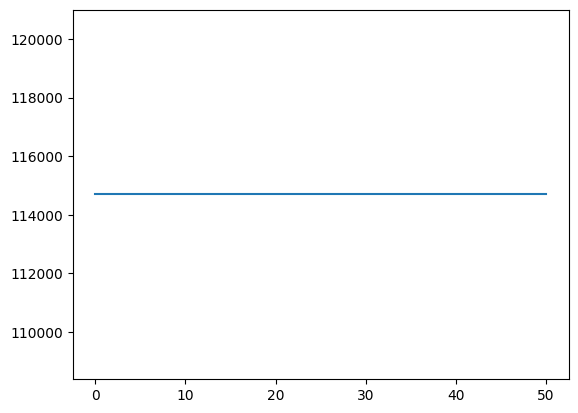

In [31]:
plt.plot(x,max_lst)

In [40]:
max([i.fitness.values for i in best_sol_pop])

(np.float64(114690.72458002997),)

In [45]:
best_solution = best_sol_pop[0]
tc = 0.01
print("TRAIN")
print("Buy and hold:",(1000/df_test.iloc[0]['Open'])*df_test.iloc[-1]['Open']*(1-tc)**2)
print("mtv         :",maximum_theoretical_value(df_test))
print("strat value :",trading_strat(individual = best_solution, df=df_test,pset=pset)[0],'\n')

TRAIN
Buy and hold: 1163.7100970760914
mtv         : 177218.81839494675
strat value : 290.61361890401014 



In [46]:
lst = []
for i in best_sol_pop:
    lst.append(trading_strat(individual = i, df=df_test,pset=pset)[0])

In [50]:
max(lst)

1401.2000275998862

In [70]:
lst_hof_test = []
for i in hof2:
    lst_hof_test.append(trading_strat(individual = i, df=df_test,pset=pset)[:2])

lst_hof_train = []
for i in hof2:
    lst_hof_train.append(trading_strat(individual = i, df=df_train ,pset=pset)[:2])

In [56]:
[i for i in lst if i>1163]

[1235.2377384287424, 1227.4131529293672, 1247.2318559636708]

In [57]:
print("Buy and hold:",(1000/df_train.iloc[0]['Open'])*df_train.iloc[-1]['Open']*(1-tc)**2)


Buy and hold: 116918.97703677377


Text(0.5, 1.0, 'Fitness values of the strategies.')

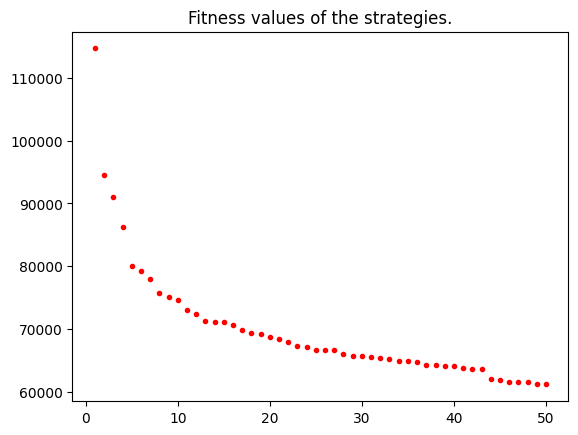

In [72]:
plt.plot(range(1,len(hof2)+1),[i.fitness.values for i in hof2],'r.')
plt.title("Fitness values of the strategies.")


Text(0.5, 1.0, 'test data')

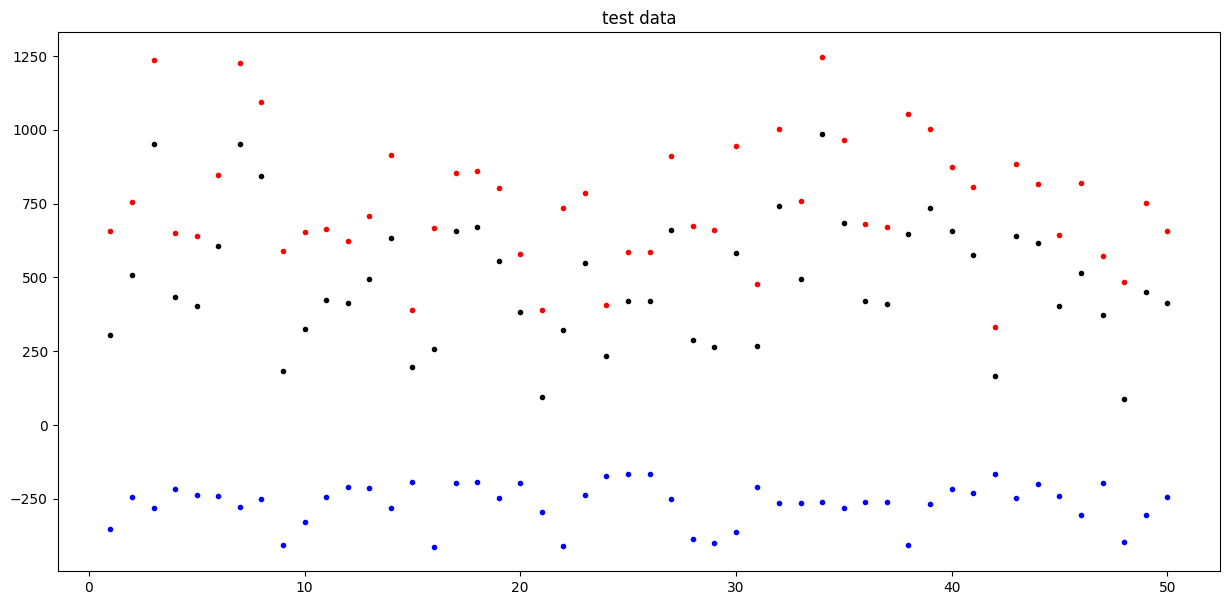

In [103]:
plt.figure(figsize=(15,7))
plt.plot(range(1,len(hof2)+1),[i[0] for i in lst_hof_test],'r.')
plt.plot(range(1,len(hof2)+1),[i[1] for i in lst_hof_test],'b.')
plt.plot(range(1,len(hof2)+1),[i[0]+i[1]  for i in lst_hof_test],'k.')


plt.title("test data")

In [107]:
[i[0]+i[1]  for i in lst_hof_test]

[306.7390954477035,
 509.64276613053556,
 953.3293185824608,
 434.21852379031384,
 404.402435773745,
 607.5699900925624,
 951.0824661588773,
 842.6631118796354,
 183.25804573613283,
 324.18746575100073,
 422.8974570479856,
 414.03128051882874,
 493.62058416206537,
 634.9584081136445,
 196.70599370027145,
 256.0959954597639,
 658.2521618069633,
 669.2359766388606,
 556.4326413708887,
 382.52085278730806,
 94.18274857417254,
 323.62758381172875,
 550.1830345297107,
 233.5729033988709,
 421.57571215586654,
 421.57571215586654,
 661.3304246178728,
 289.0452160041061,
 264.05263353205817,
 583.3401420244272,
 267.78209974826365,
 740.7877087306435,
 494.2013066224375,
 985.4261145371094,
 684.8051016301447,
 421.56504512113963,
 410.5547783229202,
 646.0915297757952,
 734.6266134161024,
 656.5223579171009,
 575.771222443756,
 165.71042833091155,
 639.8669421941879,
 615.2885790913643,
 403.1042781626223,
 515.9306491736676,
 373.9438473737109,
 89.7157451777685,
 450.0694272039324,
 413.387

[295793.37874349614, 339981.1110511845, 271161.7316884375, 235636.58870199093, 250111.49136233242, 230159.4886175766, 248158.31304762053, 229903.44454098822, 221074.59183136447, 238025.15890668816, 255822.62392409137, 219274.76830263203, 232623.1236864047, 203474.85636925296, 219472.76538547315, 233555.48151729186, 213021.79079952443, 195296.01110967604, 262045.96606228492, 263813.72805596684, 181544.2128681297, 255361.0290550985, 199710.87100405945, 170598.1549239381, 220012.92437978706, 220012.92437978706, 213539.92614985406, 228500.91173229256, 188470.44380437906, 179226.66150313005, 194740.33566013564, 224847.60276434253, 215666.25442352227, 196819.64614723736, 209765.76471756474, 165021.45363065653, 193515.21256248862, 242420.45035778166, 210926.21545434423, 229856.67492387327, 220567.77552915277, 230723.75565904123, 210312.62020104442, 160361.1037987418, 243993.46864463013, 159471.2669470412, 188298.9796772961, 206658.7492992594, 158565.62692072178, 239231.02393702837]


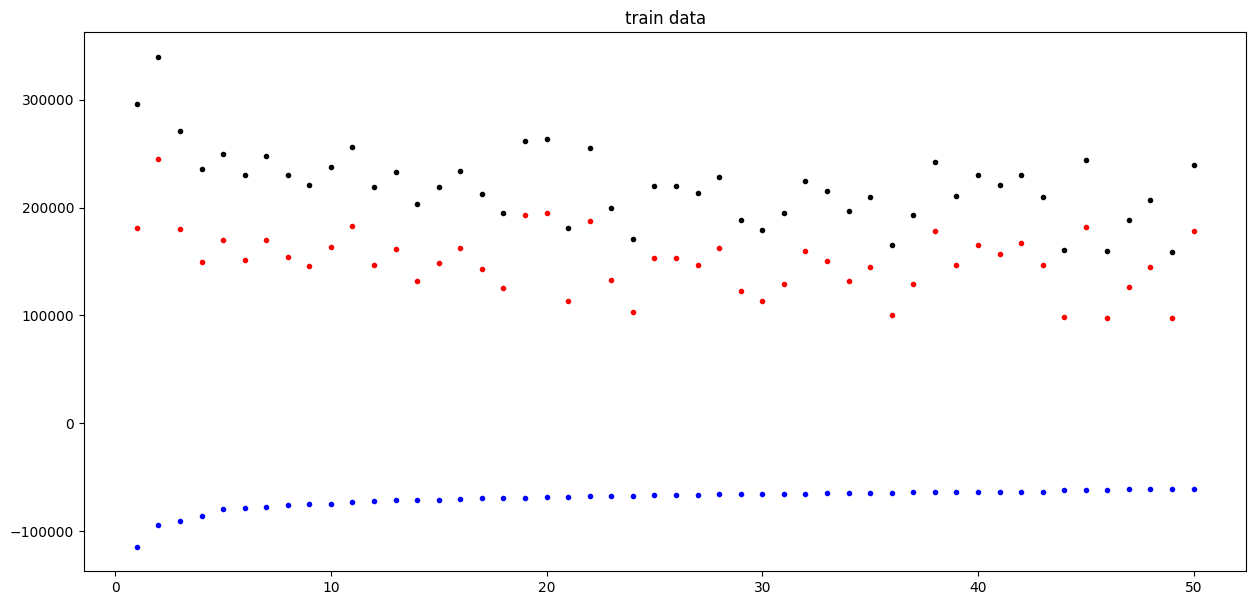

In [108]:
plt.figure(figsize=(15,7))
plt.plot(range(1,len(hof2)+1),[i[0] for i in lst_hof_train],'r.')
plt.plot(range(1,len(hof2)+1),[i[1] for i in lst_hof_train],'b.')
plt.plot(range(1,len(hof2)+1),[i[0]-i[1] for i in lst_hof_train],'k.')


plt.title("train data")
print([i[0]-i[1] for i in lst_hof_train])

In [ ]:
 maximum_theoretical_value(df, tc=tc)